<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio NLP + Sist. Recomendación


En este laboratorio, tabrajaras con datos de reseñas de productos para construir un sistema de recomendación que utilice procesamiento de lenguaje natural (NLP) y *machine learning*. El objetivo principal es que analices el contenido textual de las reseñas, clasifiques las opiniones en categorías (positiva, negativa o neutra) y aproveches esta información para personalizar las recomendaciones. El sistema priorizará los productos con mejores reseñas para usuarios específicos y permitirá evaluar si el análisis de sentimientos mejora la calidad de las recomendaciones. Tareas propuestas:




Los datos los tendréis en el [siguiente enlace](https://drive.google.com/drive/u/0/folders/1vK5zESy9KElRhm_utg_lHHXuUArrwWgu) con la descipción de cada una de las columnas.  

In [202]:
# para no tener que hacer el restart del codigo todo el rato con las funciones
# -----------------------------------------------------------------------
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import math
import re

# Visualizaciones
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Para modelos NLP
# -----------------------------------------------------------------------
import spacy
from nltk.corpus import stopwords
import nltk
import contractions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity #  Cosine Similarity post Vectorizacion


from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix


# Configuración de pandas
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)


# Otros
# -----------------------------------------------------------------------
from collections import Counter

import src.soporte_nlp as nlp
import src.soporte_sistemas_recomendacion as sr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [203]:
df = pd.read_csv("datos/datos.csv",index_col=0).reset_index(drop=True)
df.head()

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus
0,RXDM4W1ZL7L4L,"Reviewed in the United States on June 22, 2021",Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,One size does not fit all.,3.0,Nice lightweight brace but unfortunately was t...,1
1,R2GINAKQJOSWEL,"Reviewed in the United States on August 27, 2021",Computers,Men's Clothing,Fruit of the Loom Men's Coolzone Boxer Briefs,They were ok but thats it,4.0,Boxers were ok. The color did start to fade pr...,0
2,RD5R7T2JNP104,"Reviewed in the United States on May 21, 2021",Computers,Networking Products,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",Good if you need a little extra.,4.0,Very easy to install. Worked right away but it...,0
3,R3UEHJJ17E730C,"Reviewed in the United States on March 7, 2021",Home and Kitchen,Bath,"Gorilla Grip Luxury Chenille Bathroom Rug Mat,...",Color wrong!!!,1.0,The color is completely different than hunter ...,1
4,R2257OUFMQ8P5C,"Reviewed in the United States on October 17, 2020",Beauty and Personal Care,Hair Care,WOW Apple Cider Vinegar Shampoo and Hair Condi...,I have 4A hair,2.0,"From reading the reviews, I was hoping that th...",0


**Caso 1: Crear un sistema de recomendación**: Debes generar un sistema de recomendación para priorizar productos con las reseñas para cada usuario. Los pasos que deberás seguir son:    

- Estructurar el conjunto de datos

- Sistema basado en contenido


In [204]:
df.isnull().sum()

reviewId              0
reviewDate            0
mainDepartment        0
subDepartment         0
productName           0
reviewTitle           5
reviewStar            0
reviewText            1
inconsistentStatus    0
dtype: int64

In [205]:
df.dropna(inplace=True)

In [206]:
df.isnull().sum()

reviewId              0
reviewDate            0
mainDepartment        0
subDepartment         0
productName           0
reviewTitle           0
reviewStar            0
reviewText            0
inconsistentStatus    0
dtype: int64

### Reduzco el DF a lo necesario


In [207]:
df_red = df[["productName", "mainDepartment", "subDepartment", "reviewTitle", "reviewStar", "reviewText"]]

### Proceso la review del texto

In [208]:
documento = df_red["reviewText"]
vectorize = CountVectorizer()
X = vectorize.fit_transform(documento)

In [209]:
print(vectorize.get_feature_names_out())
print(X.toarray())

['00' '000' '00s' ... 'zoomed' 'zooming' 'zooms']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [210]:
X.shape

(9995, 12356)

In [211]:
print(vectorize.get_feature_names_out())
for k,v in dict(zip(documento,X.toarray())).items():
    print(f"{v} -> {k}")
    break

['00' '000' '00s' ... 'zoomed' 'zooming' 'zooms']
[0 0 0 ... 0 0 0] -> Nice lightweight brace but unfortunately was too large for my wrist.  It is adjustable, but I guess I have a small wrist and it was way too big for me.  Did not offer enough support.


### Implementamos métrica de similitud del coseno

In [212]:
similarity = cosine_similarity(X)
similarity[:20]

array([[1.        , 0.12060454, 0.23210354, ..., 0.27716093, 0.06154575,
        0.28586967],
       [0.12060454, 1.        , 0.15396007, ..., 0.25455844, 0.16329932,
        0.029173  ],
       [0.23210354, 0.15396007, 1.        , ..., 0.24494897, 0.15713484,
        0.05614346],
       ...,
       [0.        , 0.        , 0.19245009, ..., 0.        , 0.20412415,
        0.0729325 ],
       [0.24123763, 0.14770979, 0.33164556, ..., 0.40037861, 0.15075567,
        0.07181896],
       [0.        , 0.12060454, 0.05802589, ..., 0.12792043, 0.        ,
        0.        ]])

### Veamos las recomendaciones

In [213]:
df_red = df_red.rename(columns={"productName": "title"})

In [214]:
# definimos el producto
producto = df_red["title"].sample().values[0]

# buscamos el indice
producto_index = sr.get_index_from_title(producto, df_red)
# sacamos los similares
similar_products = list(enumerate(similarity[producto_index]))
similar_products[:3]

[(0, np.float64(0.23231017832142506)),
 (1, np.float64(0.30819427858908877)),
 (2, np.float64(0.3185274963874861))]

In [215]:
# ordenamos los resultados
productos_similares_ordenados = sorted(similar_products,key=lambda x:x[1],reverse=True)[1:21] # [1:21] si lo cambiamos a [0:21] la tenemos a ella misma 
productos_similares_ordenados[:3]

[(5799, np.float64(0.6410208118663929)),
 (8206, np.float64(0.6384364820846906)),
 (8677, np.float64(0.6333282398540949))]

C:\Users\ruipe\AppData\Local\Temp\ipykernel_12024\1827057734.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


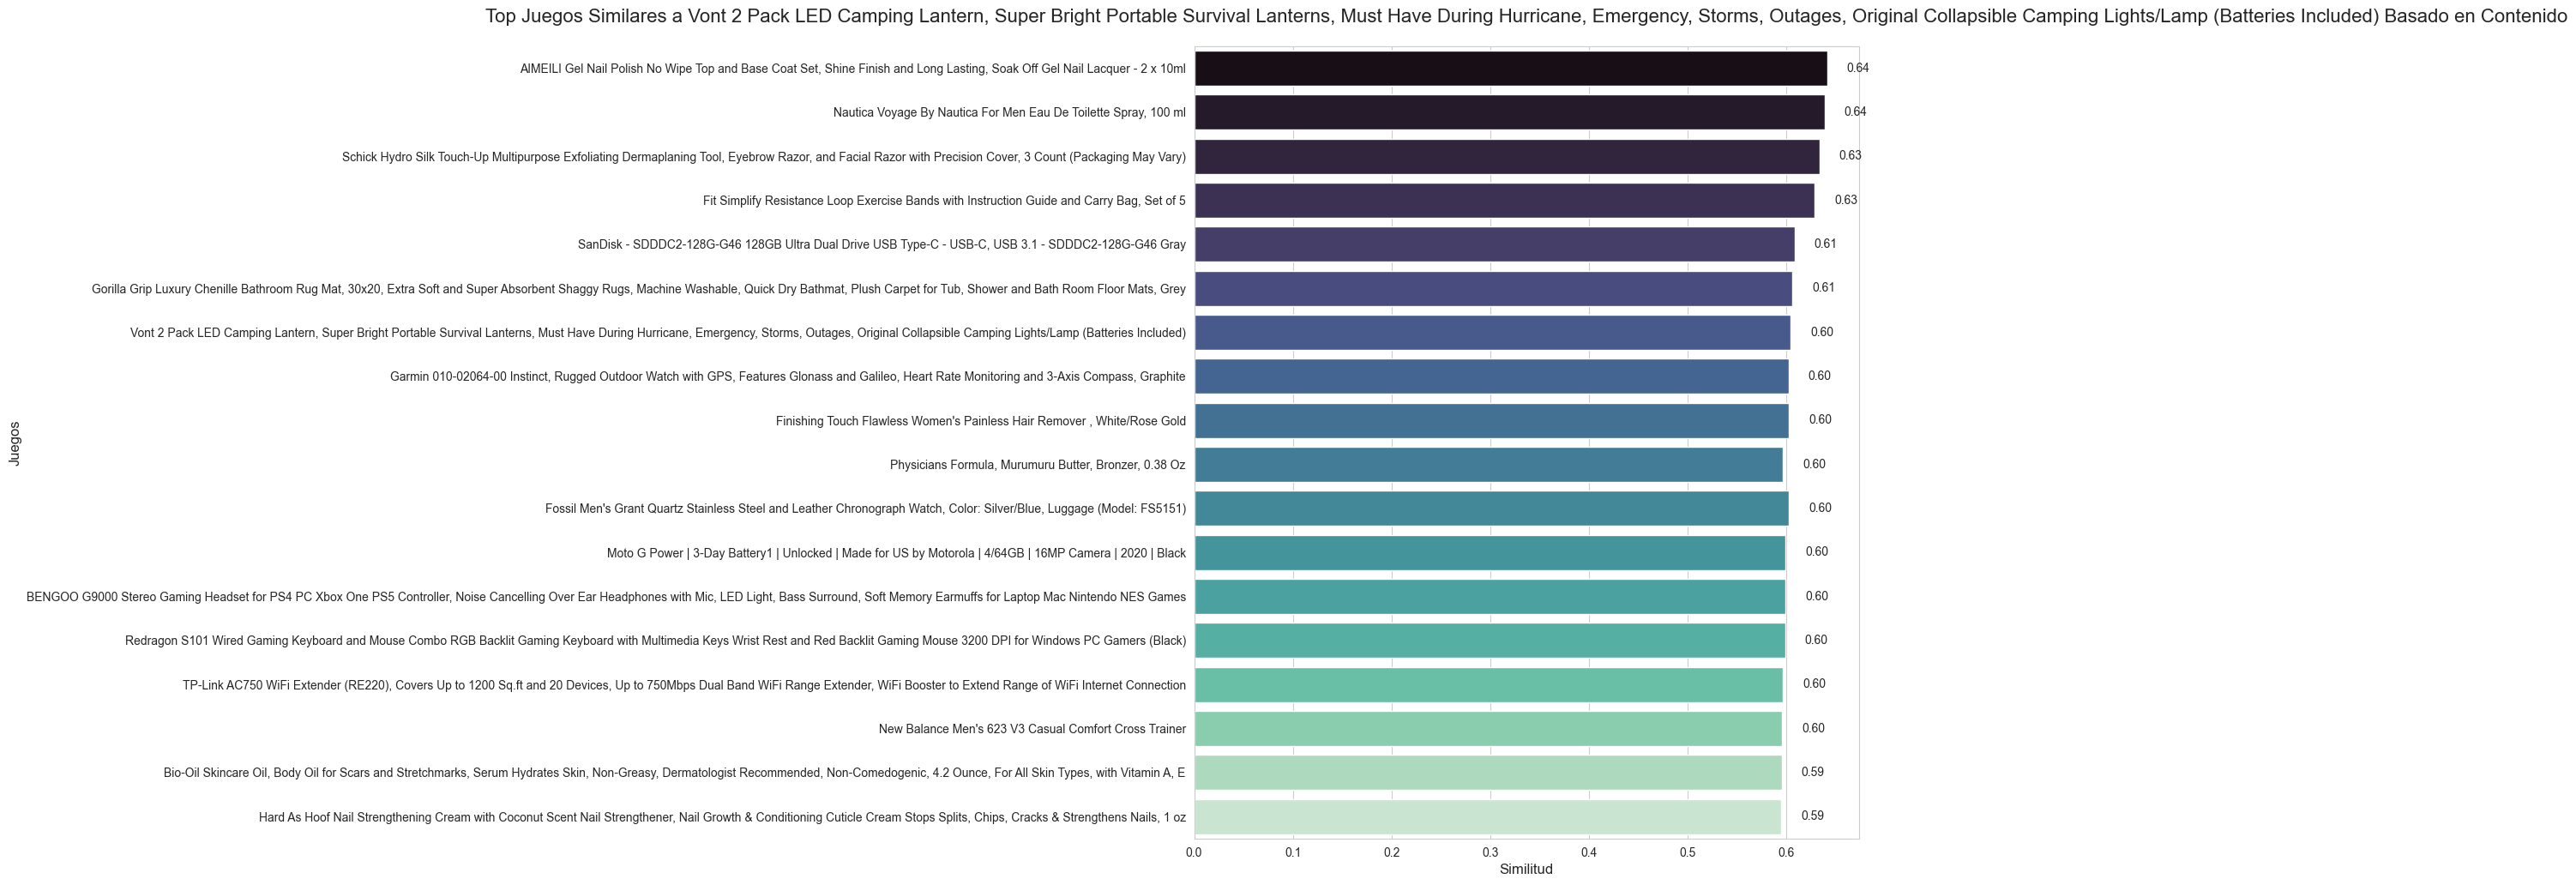

In [216]:
# y ahora buscamos el título
top_similar = {}
for i in productos_similares_ordenados:
    top_similar[sr.get_title_from_index(i[0], df_red)] = i[1]

# visualizamos los resultados
plt.figure(figsize=(10, 12))
sns.set_style("whitegrid")

# Crear gráfico de barras
sns.barplot(
    x=list(top_similar.values()), 
    y=list(top_similar.keys()), 
    hue = list(top_similar.keys()),
    palette="mako"
)

# Añadir etiquetas y título
plt.title(f"Top Juegos Similares a {producto} Basado en Contenido", fontsize=16, pad=20)
plt.xlabel("Similitud", fontsize=12)
plt.ylabel("Juegos", fontsize=12)

# Añadir valores al final de cada barra
for i, value in enumerate(top_similar.values()):
    plt.text(value + 0.02, i, f"{value:.2f}", va='center', fontsize=10)

plt.tight_layout()


**Caso 2: Clasificar reseñas en positivas, negativas o neutras** Deberás implementar un modelo para analizar las reseñas textuales y clasificarlas en tres categorías:

- Positivas: Si el sentimiento de la reseña es favorable.

- Negativas: Si el sentimiento de la reseña es desfavorable.

- Neutras: Si la reseña no tiene un sentimiento claro.
	
- Pasos :
	- Preprocesamiento de texto: Limpiar las reseñas eliminando caracteres especiales, palabras vacías (stopwords) y realizar lematización.
	
	- Identificar las reseñas positivas, negativas y neutrales. 

### Categorizar ReviewStar

In [217]:
df_red["reviewStar"].value_counts()

reviewStar
3.0    2030
4.0    2020
1.0    1988
5.0    1984
2.0    1973
Name: count, dtype: int64

In [218]:
df_red["reviewStar"] = df_red["reviewStar"].astype(int)
reviews = {
    0 : "muy insatisfecho 0/5",
    1 : "insatisfecho 1/5",
    2 : "descontento 2/5",
    3 : "tolerable 3/5",
    4 : "contento 4/5",
    5 : "muy contento 5/5"
}

df_red["reviewStar"] = df_red["reviewStar"].map(reviews)


### Explorar datos

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 9995 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           9995 non-null   object
 1   mainDepartment  9995 non-null   object
 2   subDepartment   9995 non-null   object
 3   reviewTitle     9995 non-null   object
 4   reviewStar      9995 non-null   object
 5   reviewText      9995 non-null   object
dtypes: object(6)
memory usage: 546.6+ KB
None

Descripción del DataFrame:
               count unique  \
title           9995     99   
mainDepartment  9995      5   
subDepartment   9995     27   
reviewTitle     9995   8361   
reviewStar      9995      5   
reviewText      9995   9924   

                                                              top  freq  
title           Etekcity Food Kitchen Scale, Digital Grams and...   166  
mainDepartment                                          Computers  3069  
subDe

c:\Users\ruipe\Desktop\Data Science\Semana 11\labs\modulo09-leccion06-nlp-LAB\src\soporte_nlp.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


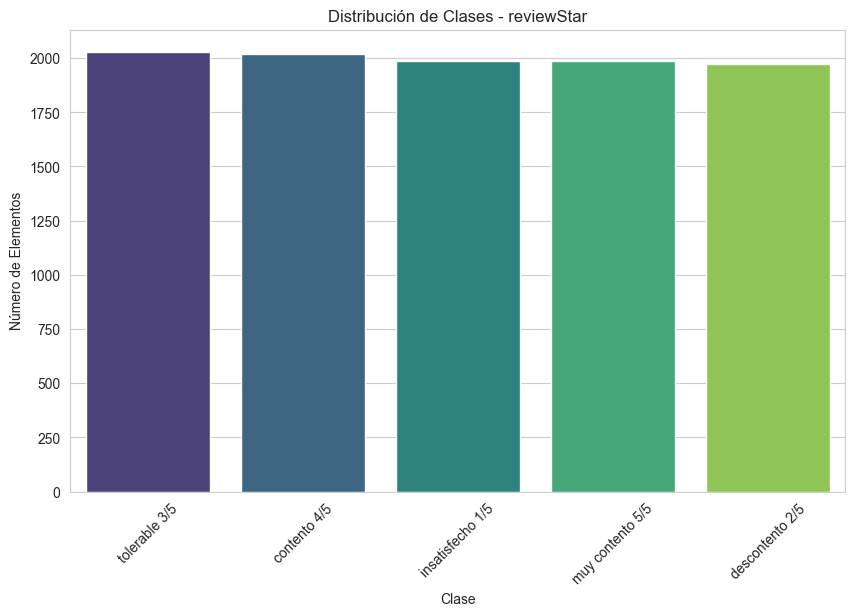

In [219]:
# Explorar los datos
exploracion = nlp.ExploracionText(df_red,"reviewText","reviewStar","english")
exploracion.explorar_datos()

### Limpieza

In [220]:
limpieza = nlp.ExploracionText(df_red,"reviewText","reviewStar","english")
limpieza.limpiar_textos(columna_limpia="review_limpia")

Limpiando el texto...


100%|██████████| 9995/9995 [01:02<00:00, 158.68it/s]

La columna 'review_limpia' se ha creado correctamente.
Texto limpiado y listo.


Generando nubes de palabras...


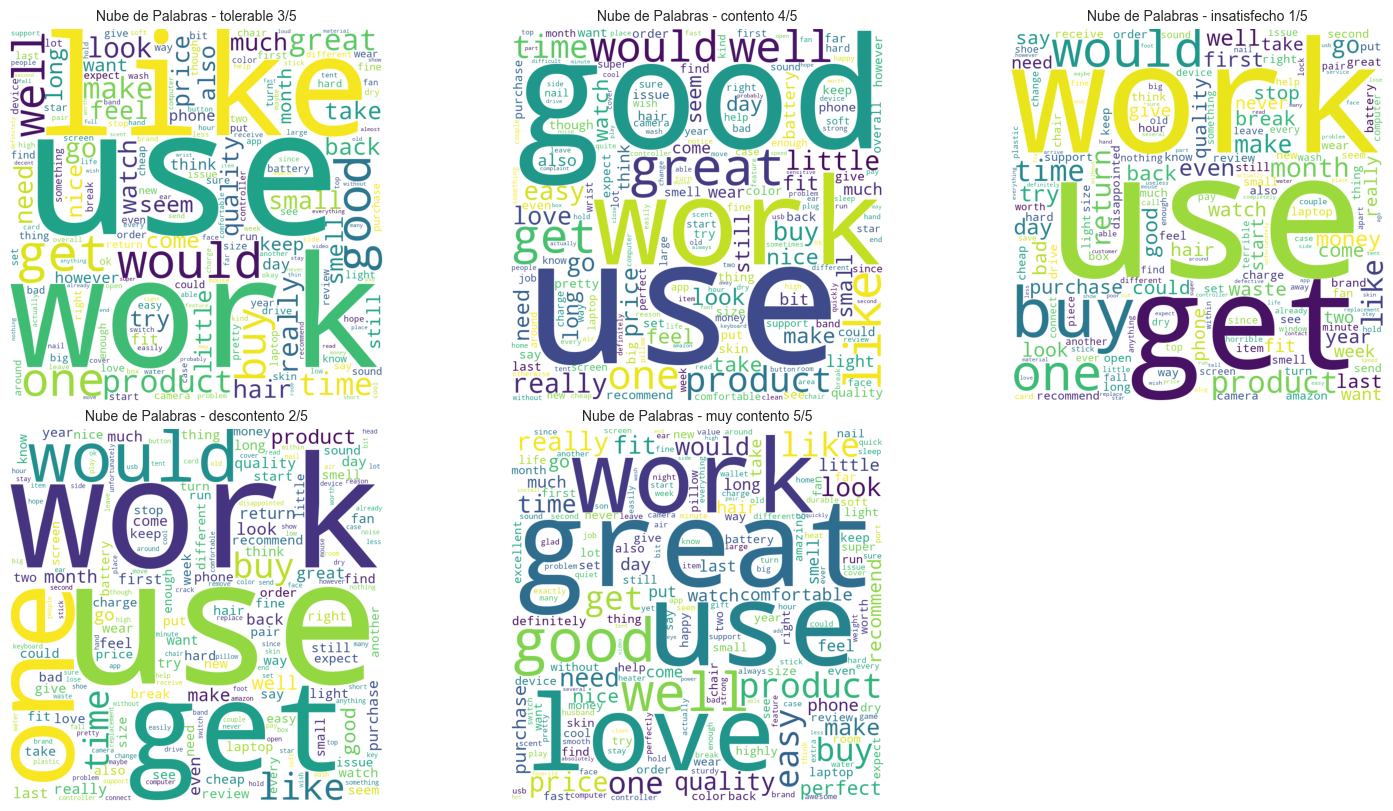

In [221]:
limpieza.generar_wordclouds()

In [222]:
df_red = limpieza.obtener_dataframe_limpio()
df_red.sample()

,title,mainDepartment,subDepartment,reviewTitle,reviewStar,reviewText,review_limpia
666,SafeRest Queen Size Premium Hypoallergenic Wat...,Home and Kitchen,Beds,Not fluid resistant at all,insatisfecho 1/5,This product provided zero protection for my m...,product provide zero protection mattress fluid...


In [223]:
representar = nlp.RepresentacionTexto(df_red,"review_limpia",max_features=2500,embedding_model="bert-base-uncased")

### Generar bow

In [224]:
df_bow = representar.generar_bow()
df_bow.sample()

Generando Bag of Words...
Bag of Words generado.


,title,mainDepartment,subDepartment,reviewTitle,reviewStar,reviewText,review_limpia,ability,able,absolute,absolutely,absorb,absorbency,absorbent,ac,accept,acceptable,access,accessory,accident,accidentally,accidently,accord,account,accuracy,accurate,accurately,acer,acne,across,acrylic,act,action,activate,active,activity,actual,actually,adapter,add,addition,additional,additionally,address,adequate,adida,adjust,adjustable,adjustment,admit,adult,advance,advanced,advantage,advertise,advertisement,advertising,advice,advise,affect,afford,affordable,afraid,afterwards,age,ago,agree,ahead,air,airflow,airpod,alarm,alcohol,alert,alexa,align,allergic,allergy,allow,almost,alone,along,alot,already,alright,also,alternative,although,always,amazing,amazingly,amazon,ambient,amount,analog,anc,andor,android,angle,angry,ankle,annoy,annoyed,annoying,another,answer,anticipate,anymore,anyone,anything,anytime,anyway,anyways,anywhere,apart,apartment,app,apparent,apparently,appear,appearance,apple,appliance,application,applicator,apply,appreciate,approximately,april,arch,area,arm,armpit,around,arrival,arrive,arthritis,aside,ask,asleep,aspect,ass,assemble,assembly,assume,assure,asus,athletic,atleast,att,attach,attachment,attempt,attention,attractive,audio,august,authentic,auto,automatic,automatically,available,average,avoid,aware,away,awesome,awful,awhile,awkward,baby,back,background,backing,backlit,backpack,backup,backyard,bad,badge,badly,bag,balance,ball,band,bang,bar,bare,barely,base,basement,basic,basically,basis,bass,batch,bath,bathroom,battery,bc,beach,bean,beanie,bear,beat,beautiful,beautifully,become,bed,bedroom,beep,begin,beginner,beginning,behind,believe,bell,belt,bend,benefit,bent,besides,bet,beware,beyond,bezel,big,bike,bill,bio,birthday,bit,black,blade,blaze,bleach,bleed,blemish,blend,blender,blind,blink,block,blow,blowout,blue,bluetooth,blurry,board,body,bolt,bone,book,boost,boot,bose,bother,bottle,bottom,bowl,box,boxer,boy,boyfriend,brace,bracelet,bracket,brand,break,breaker,breakout,breathable,breathe,breeze,brief,bright,brightness,bring,bristle,brittle,broken,bronzer,brother,brow,brown,browse,browser,brush,bubble,buck,bud,budget,bug,build,bulky,bullet,bum,bummed,bummer,bump,bumper,bunch,burn,business,bust,busy,butt,butter,button,buy,buyer,buying,cable,call,calorie,cam,came,camera,camp,camper,camping,canal,cancel,cancellation,candle,cap,capability,capacity,capture,car,card,care,careful,carefully,carhartt,carpal,carpet,carrier,carry,carrying,case,cash,castor,casual,cat,catch,catcher,cause,cd,cell,cellular,center,certain,certainly,chair,chance,change,character,charge,charger,charging,charm,chat,cheap,cheaply,check,cheek,chemical,chest,child,chill,chin,china,chinese,chip,choice,choose,christmas,chrome,chromebook,cider,circle,circulation,claim,class,classic,clean,cleaning,clear,clearly,click,clicking,client,climb,clinique,clip,clipper,clock,close,cloth,clothe,clothing,cloud,clue,clump,clumsy,coat,coating,coconut,code,coffee,cold,coleman,collapse,collar,collect,collection,college,cologne,color,combination,combo,come,comfort,comfortable,comfortably,comfy,command,comment,common,compact,company,comparable,compare,comparison,compartment,compatible,complain,complaint,complete,completely,complicated,compliment,compression,computer,con,concealer,concept,concern,condensation,condition,conditioner,conditioning,confidence,confident,configuration,configure,confirm,confuse,confused,confusing,connect,connected,connection,connectivity,connector,consider,consistency,consistent,consistently,console,constant,constantly,construct,construction,contact,contain,container,content,continually,continue,continuously,contribute,control,controller,convenience,convenient,conversation,convince,cook,cooker,cooking,cool,cooler,copper,copy,cord,corner,correct,correctly,corrector,corrupt,cost,cotton,could,count,counter,couple,course,cover,coverage,covid,coworker,cpu,crack,crap,crash,crazy,cream,create,credit,cremo,crisp,croc,crooked,cross,crown,crush,crystal,cup,cure,curl,curl

In [225]:
df_tfidf = representar.generar_tfidf()
df_tfidf.sample() 

Generando representación TF-IDF...
Representación TF-IDF generada.


,title,mainDepartment,subDepartment,reviewTitle,reviewStar,reviewText,review_limpia,ability,able,absolute,absolutely,absorb,absorbency,absorbent,ac,accept,acceptable,access,accessory,accident,accidentally,accidently,accord,account,accuracy,accurate,accurately,acer,acne,across,acrylic,act,action,activate,active,activity,actual,actually,adapter,add,addition,additional,additionally,address,adequate,adida,adjust,adjustable,adjustment,admit,adult,advance,advanced,advantage,advertise,advertisement,advertising,advice,advise,affect,afford,affordable,afraid,afterwards,age,ago,agree,ahead,air,airflow,airpod,alarm,alcohol,alert,alexa,align,allergic,allergy,allow,almost,alone,along,alot,already,alright,also,alternative,although,always,amazing,amazingly,amazon,ambient,amount,analog,anc,andor,android,angle,angry,ankle,annoy,annoyed,annoying,another,answer,anticipate,anymore,anyone,anything,anytime,anyway,anyways,anywhere,apart,apartment,app,apparent,apparently,appear,appearance,apple,appliance,application,applicator,apply,appreciate,approximately,april,arch,area,arm,armpit,around,arrival,arrive,arthritis,aside,ask,asleep,aspect,ass,assemble,assembly,assume,assure,asus,athletic,atleast,att,attach,attachment,attempt,attention,attractive,audio,august,authentic,auto,automatic,automatically,available,average,avoid,aware,away,awesome,awful,awhile,awkward,baby,back,background,backing,backlit,backpack,backup,backyard,bad,badge,badly,bag,balance,ball,band,bang,bar,bare,barely,base,basement,basic,basically,basis,bass,batch,bath,bathroom,battery,bc,beach,bean,beanie,bear,beat,beautiful,beautifully,become,bed,bedroom,beep,begin,beginner,beginning,behind,believe,bell,belt,bend,benefit,bent,besides,bet,beware,beyond,bezel,big,bike,bill,bio,birthday,bit,black,blade,blaze,bleach,bleed,blemish,blend,blender,blind,blink,block,blow,blowout,blue,bluetooth,blurry,board,body,bolt,bone,book,boost,boot,bose,bother,bottle,bottom,bowl,box,boxer,boy,boyfriend,brace,bracelet,bracket,brand,break,breaker,breakout,breathable,breathe,breeze,brief,bright,brightness,bring,bristle,brittle,broken,bronzer,brother,brow,brown,browse,browser,brush,bubble,buck,bud,budget,bug,build,bulky,bullet,bum,bummed,bummer,bump,bumper,bunch,burn,business,bust,busy,butt,butter,button,buy,buyer,buying,cable,call,calorie,cam,came,camera,camp,camper,camping,canal,cancel,cancellation,candle,cap,capability,capacity,capture,car,card,care,careful,carefully,carhartt,carpal,carpet,carrier,carry,carrying,case,cash,castor,casual,cat,catch,catcher,cause,cd,cell,cellular,center,certain,certainly,chair,chance,change,character,charge,charger,charging,charm,chat,cheap,cheaply,check,cheek,chemical,chest,child,chill,chin,china,chinese,chip,choice,choose,christmas,chrome,chromebook,cider,circle,circulation,claim,class,classic,clean,cleaning,clear,clearly,click,clicking,client,climb,clinique,clip,clipper,clock,close,cloth,clothe,clothing,cloud,clue,clump,clumsy,coat,coating,coconut,code,coffee,cold,coleman,collapse,collar,collect,collection,college,cologne,color,combination,combo,come,comfort,comfortable,comfortably,comfy,command,comment,common,compact,company,comparable,compare,comparison,compartment,compatible,complain,complaint,complete,completely,complicated,compliment,compression,computer,con,concealer,concept,concern,condensation,condition,conditioner,conditioning,confidence,confident,configuration,configure,confirm,confuse,confused,confusing,connect,connected,connection,connectivity,connector,consider,consistency,consistent,consistently,console,constant,constantly,construct,construction,contact,contain,container,content,continually,continue,continuously,contribute,control,controller,convenience,convenient,conversation,convince,cook,cooker,cooking,cool,cooler,copper,copy,cord,corner,correct,correctly,corrector,corrupt,cost,cotton,could,count,counter,couple,course,cover,coverage,covid,coworker,cpu,crack,crap,crash,crazy,cream,create,credit,cremo,crisp,croc,crooked,cross,crown,crush,crystal,cup,cure,curl,curl

In [226]:
df_embeddings = representar.generar_embeddings()
df_embeddings.sample()

Generando embeddings...
Embeddings generados.


,title,mainDepartment,subDepartment,reviewTitle,reviewStar,reviewText,review_limpia,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,embedding_34,embedding_35,embedding_36,embedding_37,embedding_38,embedding_39,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,embedding_50,embedding_51,embedding_52,embedding_53,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69,embedding_70,embedding_71,embedding_72,embedding_73,embedding_74,embedding_75,embedding_76,embedding_77,embedding_78,embedding_79,embedding_80,embedding_81,embedding_82,embedding_83,embedding_84,embedding_85,embedding_86,embedding_87,embedding_88,embedding_89,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,embedding_100,embedding_101,embedding_102,embedding_103,embedding_104,embedding_105,embedding_106,embedding_107,embedding_108,embedding_109,embedding_110,embedding_111,embedding_112,embedding_113,embedding_114,embedding_115,embedding_116,embedding_117,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,embedding_128,embedding_129,embedding_130,embedding_131,embedding_132,embedding_133,embedding_134,embedding_135,embedding_136,embedding_137,embedding_138,embedding_139,embedding_140,embedding_141,embedding_142,embedding_143,embedding_144,embedding_145,embedding_146,embedding_147,embedding_148,embedding_149,embedding_150,embedding_151,embedding_152,embedding_153,embedding_154,embedding_155,embedding_156,embedding_157,embedding_158,embedding_159,embedding_160,embedding_161,embedding_162,embedding_163,embedding_164,embedding_165,embedding_166,embedding_167,embedding_168,embedding_169,embedding_170,embedding_171,embedding_172,embedding_173,embedding_174,embedding_175,embedding_176,embedding_177,embedding_178,embedding_179,embedding_180,embedding_181,embedding_182,embedding_183,embedding_184,embedding_185,embedding_186,embedding_187,embedding_188,embedding_189,embedding_190,embedding_191,embedding_192,embedding_193,embedding_194,embedding_195,embedding_196,embedding_197,embedding_198,embedding_199,embedding_200,embedding_201,embedding_202,embedding_203,embedding_204,embedding_205,embedding_206,embedding_207,embedding_208,embedding_209,embedding_210,embedding_211,embedding_212,embedding_213,embedding_214,embedding_215,embedding_216,embedding_217,embedding_218,embedding_219,embedding_220,embedding_221,embedding_222,embedding_223,embedding_224,embedding_225,embedding_226,embedding_227,embedding_228,embedding_229,embedding_230,embedding_231,embedding_232,embedding_233,embedding_234,embedding_235,embedding_236,embedding_237,embedding_238,embedding_239,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,embedding_250,embedding_251,embedding_252,embedding_253,embedding_254,embedding_255,embedding_256,embedding_257,embedding_258,embedding_259,embedding_260,embedding_261,embedding_262,embedding_263,embedding_264,embedding_265,embedding_266,embedding_267,embedding_268,embedding_269,embedding_270,embedding_271,embedding_272,embedding_273,embedding_274,embedding_275,embedding_276,embedding_277,embedding_278,embedding_279,embedding_280,embedding_281,embedding_282,embedding_283,embedding_284,embedding_285,embedding_286,embeddin